In [1]:
# ── Cell 1: Imports & Load Combos ──────────────────────────────────
import pandas as pd
from ml_way2 import (
    load_and_normalize,
    limit_to_last_n_days,
    split_by_days,
    preprocess_1h,
    preprocess_5m,
    run_backtest,
    DATA_5M,
    DATA_1H,
    LIMITER_DAYS,
    TRAIN_PCT,
)

# load your saved top‐K CSV (adjust filename as needed)
combos = pd.read_csv("top_XGBoost_combos_filtered.csv")
combos


,ATR_WINDOW,EMA_LONG,SL_ATR_MULT,TP_ATR_MULT,VOL_MULT,RISK_PCT,REGIME_MULT,sharpe,num_entries
0,8,114,1.115595,7.894272,1.224078,0.008559,1.954206,0.799638,18


In [2]:
# ── Cell 2: Prepare Out-of-Sample Data ────────────────────────────
# 1) load full last-N-days data
df5  = limit_to_last_n_days(load_and_normalize(DATA_5M), LIMITER_DAYS)
df1h = limit_to_last_n_days(load_and_normalize(DATA_1H), LIMITER_DAYS)

# 2) split into train/test by day, then select the test slice
tr_days, ts_days = split_by_days(df5, TRAIN_PCT)
df5_ts  = df5[df5["datetime"].dt.normalize().isin(ts_days)].reset_index(drop=True)
df1h_ts = df1h[df1h["datetime"].dt.normalize().isin(ts_days)].reset_index(drop=True)

print(f"Out-of-sample bars (5m): {len(df5_ts)}")
print(f"Out-of-sample bars (1h): {len(df1h_ts)}")


Out-of-sample bars (5m): 31443
Out-of-sample bars (1h): 2621


In [3]:
# ── Cell 3: Backtest Each Combo ───────────────────────────────────
results = []

for idx, row in combos.iterrows():
    # extract just the parameter cols
    params = row.drop(["sharpe", "num_entries"]).to_dict()

    # preprocess
    hf = preprocess_1h(df1h_ts, params)
    b5 = preprocess_5m(df5_ts.copy(), params, hf)

    # backtest
    trades, metrics = run_backtest(b5, params)

    # attach params for reference
    metrics.update(params)
    results.append(metrics)

# assemble results
results_df = pd.DataFrame(results)
results_df



=== PARAMS {'ATR_WINDOW': 8.0, 'EMA_LONG': 114.0, 'SL_ATR_MULT': 1.1155952404844922, 'TP_ATR_MULT': 7.894271701451638, 'VOL_MULT': 1.2240778043361047, 'RISK_PCT': 0.008559256381869, 'REGIME_MULT': 1.9542056499130531} ===
Total bars: 31397
After EMA:       16634/31397
After RSI+BO:     672/31397
After ADX+ATR:   7662/31397
After 1h trend:  19846/31397
After vol spike: 7746/31397
After VWAP band: 13201/31397
After session:   30091/31397
After regime:     272/31397
After combine:     18 entries



,total_return_pct,annualized_return_pct,sharpe_ratio,max_drawdown_pct,win_rate_pct,num_trades,profit_factor,avg_win_usd,avg_loss_usd,max_win_usd,max_loss_usd,avg_duration_min,final_balance_usdt,ATR_WINDOW,EMA_LONG,SL_ATR_MULT,TP_ATR_MULT,VOL_MULT,RISK_PCT,REGIME_MULT
0,135.863592,2651.292661,0.799638,-8.352051,86.666667,30,5.864827,3.653806,-4.049521,10.570458,-10.106289,6.833333,136.800883,8.0,114.0,1.115595,7.894272,1.224078,0.008559,1.954206



=== PARAMS {'ATR_WINDOW': 8.0, 'EMA_LONG': 114.0, 'SL_ATR_MULT': 1.1155952404844922, 'TP_ATR_MULT': 7.894271701451638, 'VOL_MULT': 1.2240778043361047, 'RISK_PCT': 0.008559256381869, 'REGIME_MULT': 1.9542056499130531} ===
Total bars: 31397
After EMA:       16634/31397
After RSI+BO:     672/31397
After ADX+ATR:   7662/31397
After 1h trend:  19846/31397
After vol spike: 7746/31397
After VWAP band: 13201/31397
After session:   30091/31397
After regime:     272/31397
After combine:     18 entries



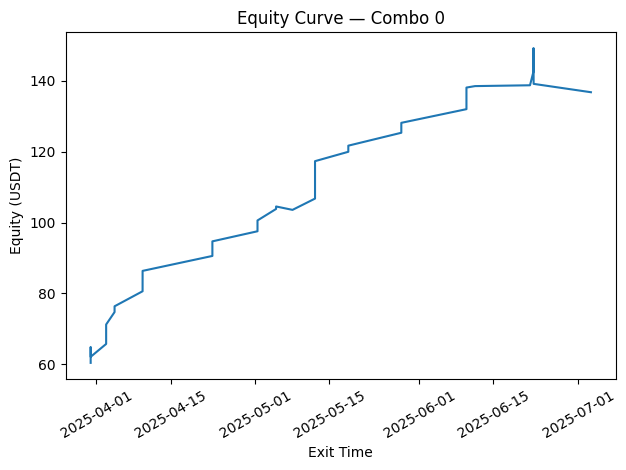

In [4]:
# ── Cell 4: (Optional) Quick Equity‐Curve Plot for Combo 0 ───────
import matplotlib.pyplot as plt

# re-run trades for combo 0 to get its trade DataFrame
params0 = combos.drop(["sharpe","num_entries"], axis=1).iloc[0].to_dict()
hf0 = preprocess_1h(df1h_ts, params0)
b50 = preprocess_5m(df5_ts.copy(), params0, hf0)
trades0, _ = run_backtest(b50, params0)

if not trades0.empty:
    plt.plot(trades0["exit_dt"], trades0["total"])
    plt.xlabel("Exit Time")
    plt.ylabel("Equity (USDT)")
    plt.title("Equity Curve — Combo 0")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
else:
    print("No trades for combo 0")


In [2]:
# ── Cell 1: Import your functions from ml_awy2.py ────────────────
import sys
sys.path.append(".")  # make sure your script’s folder is on Python’s path

import importlib.util
spec = importlib.util.spec_from_file_location("ml_way3", "./ml_way3.py")
ml = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ml)

# now ml.preprocess_1h, ml.preprocess_5m, ml.run_backtest are available


In [3]:
# ── Cell 2: Backtest Top XGBoost Combos on Last 2 Weeks Data ──
import os
import pandas as pd

# 1) Create output folder
out_folder = "xgboost_last2weeks_backtest"
os.makedirs(out_folder, exist_ok=True)

# 2) Load your top-K XGBoost combos
combos = pd.read_csv("top_XGBoost_combos_filtered.csv")

# 3) Load the 2-week 5m & 1h CSVs using your provided paths
df5_2w  = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\BTCUSDT_5m_4weeks.csv")
df1h_2w = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\BTCUSDT_1h_4weeks.csv")

# Convert epoch-ms timestamp → datetime
for df in (df5_2w, df1h_2w):
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")

# If your ml_awy2 preprocess_* expect columns named exactly 'open','high','low','close','volume', 
# you're all set. Otherwise rename columns accordingly here.

# 4) Loop through each combo and backtest
for idx, row in combos.iterrows():
    params = row.drop(["sharpe", "num_entries"]).to_dict()
    
    # Preprocess
    hf     = ml.preprocess_1h(df1h_2w, params)
    b5     = ml.preprocess_5m(df5_2w.copy(), params, hf)
    
    # Run backtest
    trades, metrics = ml.run_backtest(b5, params)
    
    # 5) Save the results
    trades.to_csv(f"{out_folder}/combo_{idx}_trades.csv", index=False)
    
    # Attach params to the metrics and save
    metrics_df = pd.DataFrame([metrics])
    for k, v in params.items():
        metrics_df[k] = v
    metrics_df.to_csv(f"{out_folder}/combo_{idx}_metrics.csv", index=False)

print("Backtest complete. Results saved in folder:", out_folder)



=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 39.0, 'SL_ATR_MULT': 0.5471437785301014, 'TP_ATR_MULT': 5.818462467582682, 'VOL_MULT': 1.6287119621526531, 'RISK_PCT': 0.0106628431321293, 'REGIME_MULT': 1.8613497108891397} ===
Total bars: 8620
After EMA:       4582/8620
After RSI+BO:     229/8620
After ADX+ATR:   2152/8620
After 1h trend:  4974/8620
After vol spike: 1247/8620
After VWAP band: 3542/8620
After session:   8260/8620
After regime:     139/8620
After combine:     12 entries


=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 140.0, 'SL_ATR_MULT': 0.9845410186311409, 'TP_ATR_MULT': 7.387515121745995, 'VOL_MULT': 2.776236377868072, 'RISK_PCT': 0.0071805217488732, 'REGIME_MULT': 1.8514413435357016} ===
Total bars: 8620
After EMA:       4898/8620
After RSI+BO:     229/8620
After ADX+ATR:   2152/8620
After 1h trend:  6145/8620
After vol spike:  360/8620
After VWAP band: 3542/8620
After session:   8260/8620
After regime:     142/8620
After combine:      9 entries


=== PARAMS {'ATR_WINDOW': 2

d:\algo_crypto\algo_crypto\mymodules\ml_way3.py:348: RuntimeWarning: divide by zero encountered in scalar divide
  pf    = df_tr.loc[df_tr['pnl_usd']>0,'pnl_usd'].sum() / -df_tr.loc[df_tr['pnl_usd']<0,'pnl_usd'].sum()



=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 34.0, 'SL_ATR_MULT': 1.0953849143023942, 'TP_ATR_MULT': 2.796294524258362, 'VOL_MULT': 2.135081696523116, 'RISK_PCT': 0.014099834413608, 'REGIME_MULT': 1.7008800486636244} ===
Total bars: 8620
After EMA:       4565/8620
After RSI+BO:     229/8620
After ADX+ATR:   2152/8620
After 1h trend:  4928/8620
After vol spike:  728/8620
After VWAP band: 3542/8620
After session:   8260/8620
After regime:     246/8620
After combine:     19 entries


=== PARAMS {'ATR_WINDOW': 7.0, 'EMA_LONG': 33.0, 'SL_ATR_MULT': 1.1043099239489558, 'TP_ATR_MULT': 3.77174296428766, 'VOL_MULT': 1.4647686461120957, 'RISK_PCT': 0.0063390854792655, 'REGIME_MULT': 1.7052241149453269} ===
Total bars: 8620
After EMA:       4566/8620
After RSI+BO:     230/8620
After ADX+ATR:   2142/8620
After 1h trend:  4925/8620
After vol spike: 1552/8620
After VWAP band: 3542/8620
After session:   8260/8620
After regime:     243/8620
After combine:     15 entries

Backtest complete. Results save

In [4]:
# ── Cell 1: Import your functions from ml_awy2.py ────────────────
import sys
sys.path.append(".")  # make sure your script’s folder is on Python’s path

import importlib.util
spec = importlib.util.spec_from_file_location("ml_way3_ethusdt", "./ml_way3_ethusdt.py")
ml = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ml)

# now ml.preprocess_1h, ml.preprocess_5m, ml.run_backtest are available


## ethereum backtest 

In [2]:
# ── Cell 2: Backtest Top XGBoost Combos on Last 2 Weeks Data ──
import os
import pandas as pd

# 1) Create output folder
out_folder = "xgboost_last2weeks_backtest_eth"
os.makedirs(out_folder, exist_ok=True)

# 2) Load your top-K XGBoost combos
combos = pd.read_csv("top_XGBoost_combos_filtered_eth.csv")

# 3) Load the 2-week 5m & 1h CSVs using your provided paths
df5_2w  = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\ETHUSDT_5m_4weeks.csv")
df1h_2w = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\ETHUSDT_1h_4weeks.csv")

# Convert epoch-ms timestamp → datetime
for df in (df5_2w, df1h_2w):
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")

# If your ml_awy2 preprocess_* expect columns named exactly 'open','high','low','close','volume', 
# you're all set. Otherwise rename columns accordingly here.

# 4) Loop through each combo and backtest
for idx, row in combos.iterrows():
    params = row.drop(["sharpe", "num_entries"]).to_dict()
    
    # Preprocess
    hf     = ml.preprocess_1h(df1h_2w, params)
    b5     = ml.preprocess_5m(df5_2w.copy(), params, hf)
    
    # Run backtest
    trades, metrics = ml.run_backtest(b5, params)
    
    # 5) Save the results
    trades.to_csv(f"{out_folder}/combo_{idx}_trades_eth.csv", index=False)
    
    # Attach params to the metrics and save
    metrics_df = pd.DataFrame([metrics])
    for k, v in params.items():
        metrics_df[k] = v
    metrics_df.to_csv(f"{out_folder}/combo_{idx}_metrics_eth.csv", index=False)

print("Backtest complete. Results saved in folder:", out_folder)



=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 39.0, 'SL_ATR_MULT': 0.5471437785301014, 'TP_ATR_MULT': 5.818462467582682, 'VOL_MULT': 1.6287119621526531, 'RISK_PCT': 0.0106628431321293, 'REGIME_MULT': 1.8613497108891397} ===
Total bars: 8620
After EMA:       4620/8620
After RSI+BO:     166/8620
After ADX+ATR:   2217/8620
After 1h trend:  5005/8620
After vol spike: 1203/8620
After VWAP band: 4056/8620
After session:   8260/8620
After regime:     118/8620
After combine:     16 entries


=== PARAMS {'ATR_WINDOW': 5.0, 'EMA_LONG': 50.0, 'SL_ATR_MULT': 1.569569075951478, 'TP_ATR_MULT': 5.998312481469239, 'VOL_MULT': 2.9320950102573544, 'RISK_PCT': 0.0154597180147648, 'REGIME_MULT': 1.926159061597007} ===
Total bars: 8620
After EMA:       4714/8620
After RSI+BO:     162/8620
After ADX+ATR:   2216/8620
After 1h trend:  5203/8620
After vol spike:  351/8620
After VWAP band: 4056/8620
After session:   8260/8620
After regime:      93/8620
After combine:     18 entries


=== PARAMS {'ATR_WINDOW': 8.0

## eth backtest on 1 day

In [5]:
# ── Cell 2: Backtest Top XGBoost Combos on Last 2 Weeks Data ──
import os
import pandas as pd

# 1) Create output folder
out_folder = "xgboost_last2weeks_backtest_eth"
os.makedirs(out_folder, exist_ok=True)

# 2) Load your top-K XGBoost combos
combos = pd.read_csv("top_XGBoost_combos_filtered_eth.csv")

# 3) Load the 2-week 5m & 1h CSVs using your provided paths
df5_2w  = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\ETHUSDT_5m_1day.csv")
df1h_2w = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\ETHUSDT_1h_1day.csv")

# Convert epoch-ms timestamp → datetime
for df in (df5_2w, df1h_2w):
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")

# If your ml_awy2 preprocess_* expect columns named exactly 'open','high','low','close','volume', 
# you're all set. Otherwise rename columns accordingly here.

# 4) Loop through each combo and backtest
for idx, row in combos.iterrows():
    params = row.drop(["sharpe", "num_entries"]).to_dict()
    
    # Preprocess
    hf     = ml.preprocess_1h(df1h_2w, params)
    b5     = ml.preprocess_5m(df5_2w.copy(), params, hf)
    
    # Run backtest
    trades, metrics = ml.run_backtest(b5, params)
    
    # 5) Save the results
    trades.to_csv(f"{out_folder}/combo_{idx}_trades_eth.csv", index=False)
    
    # Attach params to the metrics and save
    metrics_df = pd.DataFrame([metrics])
    for k, v in params.items():
        metrics_df[k] = v
    metrics_df.to_csv(f"{out_folder}/combo_{idx}_metrics_eth.csv", index=False)

print("Backtest complete. Results saved in folder:", out_folder)



=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 39.0, 'SL_ATR_MULT': 0.5471437785301014, 'TP_ATR_MULT': 5.818462467582682, 'VOL_MULT': 1.6287119621526531, 'RISK_PCT': 0.0106628431321293, 'REGIME_MULT': 1.8613497108891397} ===
Total bars: 268
After EMA:        168/268
After RSI+BO:       7/268
After ADX+ATR:     84/268
After 1h trend:   254/268
After vol spike:   42/268
After VWAP band:  194/268
After session:    256/268
After regime:       0/268
After combine:      0 entries


=== PARAMS {'ATR_WINDOW': 5.0, 'EMA_LONG': 50.0, 'SL_ATR_MULT': 1.569569075951478, 'TP_ATR_MULT': 5.998312481469239, 'VOL_MULT': 2.9320950102573544, 'RISK_PCT': 0.0154597180147648, 'REGIME_MULT': 1.926159061597007} ===
Total bars: 268
After EMA:        175/268
After RSI+BO:       7/268
After ADX+ATR:     88/268
After 1h trend:   254/268
After vol spike:    8/268
After VWAP band:  194/268
After session:    256/268
After regime:       0/268
After combine:      0 entries


=== PARAMS {'ATR_WINDOW': 8.0, 'EMA_LONG': 124.

## eth backtest on 7 day

In [8]:
# ── Cell 2: Backtest Top XGBoost Combos on Last 2 Weeks Data ──
import os
import pandas as pd

# 1) Create output folder
out_folder = "xgboost_last2weeks_backtest_eth"
os.makedirs(out_folder, exist_ok=True)

# 2) Load your top-K XGBoost combos
combos = pd.read_csv("top_XGBoost_combos_filtered_eth.csv")

# 3) Load the 2-week 5m & 1h CSVs using your provided paths
df5_2w  = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\ETHUSDT_5m_7day.csv")
df1h_2w = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\ETHUSDT_1h_7day.csv")

# Convert epoch-ms timestamp → datetime
for df in (df5_2w, df1h_2w):
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")

# If your ml_awy2 preprocess_* expect columns named exactly 'open','high','low','close','volume', 
# you're all set. Otherwise rename columns accordingly here.

# 4) Loop through each combo and backtest
for idx, row in combos.iterrows():
    params = row.drop(["sharpe", "num_entries"]).to_dict()
    
    # Preprocess
    hf     = ml.preprocess_1h(df1h_2w, params)
    b5     = ml.preprocess_5m(df5_2w.copy(), params, hf)
    
    # Run backtest
    trades, metrics = ml.run_backtest(b5, params)
    
    # 5) Save the results
    trades.to_csv(f"{out_folder}/combo_{idx}_trades_eth.csv", index=False)
    
    # Attach params to the metrics and save
    metrics_df = pd.DataFrame([metrics])
    for k, v in params.items():
        metrics_df[k] = v
    metrics_df.to_csv(f"{out_folder}/combo_{idx}_metrics_eth.csv", index=False)

print("Backtest complete. Results saved in folder:", out_folder)



=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 39.0, 'SL_ATR_MULT': 0.5471437785301014, 'TP_ATR_MULT': 5.818462467582682, 'VOL_MULT': 1.6287119621526531, 'RISK_PCT': 0.0106628431321293, 'REGIME_MULT': 1.8613497108891397} ===
Total bars: 1996
After EMA:       1217/1996
After RSI+BO:      39/1996
After ADX+ATR:    666/1996
After 1h trend:  1357/1996
After vol spike:  267/1996
After VWAP band: 1245/1996
After session:   1912/1996
After regime:      10/1996
After combine:      2 entries


=== PARAMS {'ATR_WINDOW': 5.0, 'EMA_LONG': 50.0, 'SL_ATR_MULT': 1.569569075951478, 'TP_ATR_MULT': 5.998312481469239, 'VOL_MULT': 2.9320950102573544, 'RISK_PCT': 0.0154597180147648, 'REGIME_MULT': 1.926159061597007} ===
Total bars: 1996
After EMA:       1224/1996
After RSI+BO:      38/1996
After ADX+ATR:    670/1996
After 1h trend:  1345/1996
After vol spike:   71/1996
After VWAP band: 1245/1996
After session:   1912/1996
After regime:       6/1996
After combine:      1 entries


=== PARAMS {'ATR_WINDOW': 8.0

d:\algo_crypto\algo_crypto\mymodules\ml_way3_ethusdt.py:349: RuntimeWarning: divide by zero encountered in scalar divide
  pf    = df_tr.loc[df_tr['pnl_usd']>0,'pnl_usd'].sum() / -df_tr.loc[df_tr['pnl_usd']<0,'pnl_usd'].sum()
d:\algo_crypto\algo_crypto\mymodules\ml_way3_ethusdt.py:342: RuntimeWarning: overflow encountered in scalar power
  cagr  = (1+tot)**(365/days)-1 if days>0 else np.nan
d:\algo_crypto\algo_crypto\mymodules\ml_way3_ethusdt.py:349: RuntimeWarning: divide by zero encountered in scalar divide
  pf    = df_tr.loc[df_tr['pnl_usd']>0,'pnl_usd'].sum() / -df_tr.loc[df_tr['pnl_usd']<0,'pnl_usd'].sum()
d:\algo_crypto\algo_crypto\mymodules\ml_way3_ethusdt.py:342: RuntimeWarning: overflow encountered in scalar power
  cagr  = (1+tot)**(365/days)-1 if days>0 else np.nan
d:\algo_crypto\algo_crypto\mymodules\ml_way3_ethusdt.py:349: RuntimeWarning: divide by zero encountered in scalar divide
  pf    = df_tr.loc[df_tr['pnl_usd']>0,'pnl_usd'].sum() / -df_tr.loc[df_tr['pnl_usd']<0,'pn

After combine:      2 entries


=== PARAMS {'ATR_WINDOW': 7.0, 'EMA_LONG': 102.0, 'SL_ATR_MULT': 1.5991002121792477, 'TP_ATR_MULT': 5.640390348304619, 'VOL_MULT': 2.34574333719616, 'RISK_PCT': 0.0025418343921885, 'REGIME_MULT': 1.9272360652651808} ===
Total bars: 1996
After EMA:       1322/1996
After RSI+BO:      38/1996
After ADX+ATR:    657/1996
After 1h trend:  1331/1996
After vol spike:  122/1996
After VWAP band: 1245/1996
After session:   1912/1996
After regime:       7/1996
After combine:      0 entries

Backtest complete. Results saved in folder: xgboost_last2weeks_backtest_eth


In [3]:
# Code cell: verify no date overlap between ML slice and 4‑week backtest

import pandas as pd

# --- 1) Load full 5y dataset and parse datetime ---
df_full = pd.read_csv("data/ETHUSDT_5m_5year.csv")
if 'open_time' in df_full:
    df_full['datetime'] = pd.to_datetime(df_full['open_time'], unit='ms')
elif 'timestamp' in df_full:
    df_full['datetime'] = pd.to_datetime(df_full['timestamp'], unit='ms')
else:
    df_full['datetime'] = pd.to_datetime(df_full['datetime'])

# --- 2) Limit to the earliest N days (oldest 4 years) ---
N = 1460
all_days = df_full['datetime'].dt.normalize().drop_duplicates().sort_values()
first_days = all_days.iloc[:N]
df_ml = df_full[df_full['datetime'].dt.normalize().isin(first_days)]

# --- 3) Split into train/val ---
TRAIN_PCT = 0.7
cut = int(len(first_days) * TRAIN_PCT)
tr_days = first_days.iloc[:cut]
val_days = first_days.iloc[cut:]

# --- Print ML slice and splits ---
print("ML slice covers:    ", first_days.min().date(), "→", first_days.max().date())
print("  • Train covers:   ", tr_days.min().date(), "→", tr_days.max().date())
print("  • Validation covers:", val_days.min().date(), "→", val_days.max().date())

# --- 4) Load 4‑week backtest data and parse datetime ---
df_bt = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\BTCUSDT_5m_4weeks.csv")
df_bt['datetime'] = pd.to_datetime(df_bt['timestamp'], unit='ms')

print("Backtest covers:    ", df_bt['datetime'].min().date(), "→", df_bt['datetime'].max().date())

# --- 5) Compute overlap ---
ml_dates = set(df_ml['datetime'].dt.normalize())
bt_dates = set(df_bt['datetime'].dt.normalize())
overlap = sorted(ml_dates & bt_dates)

print("Overlap days count:", len(overlap))
if overlap:
    print("Sample overlapping dates:", overlap[:5])


ML slice covers:     2020-07-05 → 2024-07-03
  • Train covers:    2020-07-05 → 2023-04-21
  • Validation covers: 2023-04-22 → 2024-07-03
Backtest covers:     2025-06-15 → 2025-07-15
Overlap days count: 0


## TEST ON 1 YEAR UNSEEN DATA 

In [4]:
# ── Cell 2: Backtest Top XGBoost Combos on Last 2 Weeks Data ──
import os
import pandas as pd

# 1) Create output folder
out_folder = "xgboost_last2weeks_backtest"
os.makedirs(out_folder, exist_ok=True)

# 2) Load your top-K XGBoost combos
combos = pd.read_csv("top_XGBoost_combos_filtered.csv")

# 3) Load the 2-week 5m & 1h CSVs using your provided paths
df5_2w  = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\ETHUSDT_5m_1YEAR.csv")
df1h_2w = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\ETHUSDT_1h_1YEAR.csv")

# Convert epoch-ms timestamp → datetime
for df in (df5_2w, df1h_2w):
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")

# If your ml_awy2 preprocess_* expect columns named exactly 'open','high','low','close','volume', 
# you're all set. Otherwise rename columns accordingly here.

# 4) Loop through each combo and backtest
for idx, row in combos.iterrows():
    params = row.drop(["sharpe", "num_entries"]).to_dict()
    
    # Preprocess
    hf     = ml.preprocess_1h(df1h_2w, params)
    b5     = ml.preprocess_5m(df5_2w.copy(), params, hf)
    
    # Run backtest
    trades, metrics = ml.run_backtest(b5, params)
    
    # 5) Save the results
    trades.to_csv(f"{out_folder}/combo_{idx}_trades.csv", index=False)
    
    # Attach params to the metrics and save
    metrics_df = pd.DataFrame([metrics])
    for k, v in params.items():
        metrics_df[k] = v
    metrics_df.to_csv(f"{out_folder}/combo_{idx}_metrics.csv", index=False)

print("Backtest complete. Results saved in folder:", out_folder)



=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 39.0, 'SL_ATR_MULT': 0.5471437785301014, 'TP_ATR_MULT': 5.818462467582682, 'VOL_MULT': 1.6287119621526531, 'RISK_PCT': 0.0106628431321293, 'REGIME_MULT': 1.8613497108891397} ===
Total bars: 105008
After EMA:       54309/105008
After RSI+BO:    1920/105008
After ADX+ATR:   26650/105008
After 1h trend:  54853/105008
After vol spike: 14729/105008
After VWAP band: 48688/105008
After session:   100644/105008
After regime:    1080/105008
After combine:    152 entries


=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 140.0, 'SL_ATR_MULT': 0.9845410186311409, 'TP_ATR_MULT': 7.387515121745995, 'VOL_MULT': 2.776236377868072, 'RISK_PCT': 0.0071805217488732, 'REGIME_MULT': 1.8514413435357016} ===
Total bars: 105008
After EMA:       54158/105008
After RSI+BO:    1920/105008
After ADX+ATR:   26650/105008
After 1h trend:  52555/105008
After vol spike: 4515/105008
After VWAP band: 48688/105008
After session:   100644/105008
After regime:    1125/105008
After comb

d:\algo_crypto\algo_crypto\mymodules\ml_way3.py:348: RuntimeWarning: divide by zero encountered in scalar divide
  pf    = df_tr.loc[df_tr['pnl_usd']>0,'pnl_usd'].sum() / -df_tr.loc[df_tr['pnl_usd']<0,'pnl_usd'].sum()



=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 34.0, 'SL_ATR_MULT': 1.0953849143023942, 'TP_ATR_MULT': 2.796294524258362, 'VOL_MULT': 2.135081696523116, 'RISK_PCT': 0.014099834413608, 'REGIME_MULT': 1.7008800486636244} ===
Total bars: 105008
After EMA:       54346/105008
After RSI+BO:    1920/105008
After ADX+ATR:   26650/105008
After 1h trend:  54912/105008
After vol spike: 8336/105008
After VWAP band: 48688/105008
After session:   100644/105008
After regime:    2078/105008
After combine:    246 entries


=== PARAMS {'ATR_WINDOW': 7.0, 'EMA_LONG': 33.0, 'SL_ATR_MULT': 1.1043099239489558, 'TP_ATR_MULT': 3.77174296428766, 'VOL_MULT': 1.4647686461120957, 'RISK_PCT': 0.0063390854792655, 'REGIME_MULT': 1.7052241149453269} ===
Total bars: 105008
After EMA:       54357/105008
After RSI+BO:    1958/105008
After ADX+ATR:   26641/105008
After 1h trend:  54931/105008
After vol spike: 18210/105008
After VWAP band: 48688/105008
After session:   100644/105008
After regime:    2075/105008
After combine

## 1day unseen data

In [18]:
# ── Cell 2: Backtest Top XGBoost Combos on Last 2 Weeks Data ──
import os
import pandas as pd

# 1) Create output folder
out_folder = "xgboost_last2weeks_backtest"
os.makedirs(out_folder, exist_ok=True)

# 2) Load your top-K XGBoost combos
combos = pd.read_csv("top_XGBoost_combos_filtered.csv")

# 3) Load the 2-week 5m & 1h CSVs using your provided paths
df5_2w  = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\BTCUSDT_5m_1day.csv")
df1h_2w = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\BTCUSDT_1h_1day.csv")

# Convert epoch-ms timestamp → datetime
for df in (df5_2w, df1h_2w):
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")

# If your ml_awy2 preprocess_* expect columns named exactly 'open','high','low','close','volume', 
# you're all set. Otherwise rename columns accordingly here.

# 4) Loop through each combo and backtest
for idx, row in combos.iterrows():
    params = row.drop(["sharpe", "num_entries"]).to_dict()
    
    # Preprocess
    hf     = ml.preprocess_1h(df1h_2w, params)
    b5     = ml.preprocess_5m(df5_2w.copy(), params, hf)
    
    # Run backtest
    trades, metrics = ml.run_backtest(b5, params)
    
    # 5) Save the results
    trades.to_csv(f"{out_folder}/combo_{idx}_trades.csv", index=False)
    
    # Attach params to the metrics and save
    metrics_df = pd.DataFrame([metrics])
    for k, v in params.items():
        metrics_df[k] = v
    metrics_df.to_csv(f"{out_folder}/combo_{idx}_metrics.csv", index=False)

print("Backtest complete. Results saved in folder:", out_folder)



=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 39.0, 'SL_ATR_MULT': 0.5471437785301014, 'TP_ATR_MULT': 5.818462467582682, 'VOL_MULT': 1.6287119621526531, 'RISK_PCT': 0.0106628431321293, 'REGIME_MULT': 1.8613497108891397} ===
Total bars: 268
After EMA:        115/268
After RSI+BO:       5/268
After ADX+ATR:     85/268
After 1h trend:    24/268
After vol spike:   38/268
After VWAP band:  108/268
After session:    256/268
After regime:       0/268
After combine:      0 entries


=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 140.0, 'SL_ATR_MULT': 0.9845410186311409, 'TP_ATR_MULT': 7.387515121745995, 'VOL_MULT': 2.776236377868072, 'RISK_PCT': 0.0071805217488732, 'REGIME_MULT': 1.8514413435357016} ===
Total bars: 268
After EMA:         84/268
After RSI+BO:       5/268
After ADX+ATR:     85/268
After 1h trend:    16/268
After vol spike:    9/268
After VWAP band:  108/268
After session:    256/268
After regime:       0/268
After combine:      0 entries


=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 34

d:\algo_crypto\algo_crypto\mymodules\ml_way2.py:343: RuntimeWarning: divide by zero encountered in scalar divide
  pf    = df_tr.loc[df_tr['pnl_usd']>0,'pnl_usd'].sum() / -df_tr.loc[df_tr['pnl_usd']<0,'pnl_usd'].sum()
d:\algo_crypto\algo_crypto\mymodules\ml_way2.py:343: RuntimeWarning: divide by zero encountered in scalar divide
  pf    = df_tr.loc[df_tr['pnl_usd']>0,'pnl_usd'].sum() / -df_tr.loc[df_tr['pnl_usd']<0,'pnl_usd'].sum()


## histgbm combos 1 day testing

In [6]:
# ── Cell 2: Backtest Top XGBoost Combos on Last 2 Weeks Data ──
import os
import pandas as pd

# 1) Create output folder
out_folder = "histgbm_last2weeks_backtest"
os.makedirs(out_folder, exist_ok=True)

# 2) Load your top-K XGBoost combos
combos = pd.read_csv("top_HistGBM_combos_filtered.csv")

# 3) Load the 2-week 5m & 1h CSVs using your provided paths
df5_2w  = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\BTCUSDT_5m_1day.csv")
df1h_2w = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\data\BTCUSDT_1h_1day.csv")

# Convert epoch-ms timestamp → datetime
for df in (df5_2w, df1h_2w):
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")

# If your ml_awy2 preprocess_* expect columns named exactly 'open','high','low','close','volume', 
# you're all set. Otherwise rename columns accordingly here.

# 4) Loop through each combo and backtest
for idx, row in combos.iterrows():
    params = row.drop(["sharpe", "num_entries"]).to_dict()
    
    # Preprocess
    hf     = ml.preprocess_1h(df1h_2w, params)
    b5     = ml.preprocess_5m(df5_2w.copy(), params, hf)
    
    # Run backtest
    trades, metrics = ml.run_backtest(b5, params)
    
    # 5) Save the results
    trades.to_csv(f"{out_folder}/combo_{idx}_trades.csv", index=False)
    
    # Attach params to the metrics and save
    metrics_df = pd.DataFrame([metrics])
    for k, v in params.items():
        metrics_df[k] = v
    metrics_df.to_csv(f"{out_folder}/combo_{idx}_metrics.csv", index=False)

print("Backtest complete. Results saved in folder:", out_folder)



=== PARAMS {'ATR_WINDOW': 45.0, 'EMA_LONG': 140.0, 'SL_ATR_MULT': 1.3406609464706598, 'TP_ATR_MULT': 2.6659368152808867, 'VOL_MULT': 1.8941110876128509, 'RISK_PCT': 0.0097468071528366, 'REGIME_MULT': 1.796845414284005} ===
Total bars: 155
After EMA:         28/155
After RSI+BO:       2/155
After ADX+ATR:     64/155
After 1h trend:    42/155
After vol spike:   15/155
After VWAP band:   51/155
After session:    143/155
After regime:       0/155
After combine:      0 entries

Backtest complete. Results saved in folder: histgbm_last2weeks_backtest


In [7]:
!pwd


/d/algo_crypto/algo_crypto/mymodules


## LIVE MARKET DEPLOYMENT AND TESTING

In [4]:
!pip install python-dotenv



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
from dotenv import load_dotenv
from binance.client import Client

# 1) Load your .env file
load_dotenv(dotenv_path=".env")

# 2) Read keys
API_KEY    = os.getenv("BINANCE_FUTURES_API_KEY")
API_SECRET = os.getenv("BINANCE_FUTURES_SECRET_KEY")

# 3) Initialize client for USDT‑M Futures testnet or mainnet
client = Client(API_KEY, API_SECRET)

# If you’re paper‑trading on the testnet use:
client.API_URL = "https://testnet.binancefuture.com"

# Otherwise (live trading) the default is mainnet:
# client.API_URL = "https://fapi.binance.com"


In [ ]:
# ── Cell: Continuous Live Paper‑Trading Loop ───────────────────────
import os, sys, time, math
from datetime import datetime
import pandas as pd
from binance.client import Client
from dotenv import load_dotenv
import importlib.util

# 1) Load your API keys
load_dotenv(".env")
API_KEY    = os.getenv("BINANCE_FUTURES_API_KEY")
API_SECRET = os.getenv("BINANCE_FUTURES_SECRET_KEY")
if not API_KEY or not API_SECRET:
    raise RuntimeError("Set API keys in .env")

# 2) Initialize & point client
client = Client(API_KEY, API_SECRET)
client.API_URL     = "https://testnet.binancefuture.com"
client.FUTURES_URL = "https://testnet.binancefuture.com/fapi"

# 3) Import ML functions
sys.path.append(".")
spec = importlib.util.spec_from_file_location("ml_way2", "./ml_way2.py")
ml = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ml)
preprocess_1h, preprocess_5m, find_entries = ml.preprocess_1h, ml.preprocess_5m, ml.find_entries

# 4) Load combo & settings
combo = pd.read_csv("use_this_combi.csv").iloc[0]
params = combo.drop(["sharpe", "num_entries"]).to_dict()
SYMBOL, LEVERAGE, CONTRACT_SZ, USDT_CAPITAL = "BTCUSDT", 10, 0.001, 58.0
trade_file, metrics_file = "testnet_trades.csv", "testnet_metrics.csv"
metrics_cols = [ "total_return_pct","annualized_return_pct","sharpe_ratio","max_drawdown_pct",
                 "win_rate_pct","num_trades","profit_factor","avg_win_usd","avg_loss_usd",
                 "max_win_usd","max_loss_usd","avg_duration_min","final_balance_usdt",
                 "ATR_WINDOW","EMA_LONG","SL_ATR_MULT","TP_ATR_MULT","VOL_MULT",
                 "RISK_PCT","REGIME_MULT" ]

# Ensure CSVs exist
if not os.path.exists(trade_file):
    with open(trade_file, "w") as f:
        f.write("timestamp,side,quantity,entry_price\n")
if not os.path.exists(metrics_file):
    pd.DataFrame(columns=metrics_cols).to_csv(metrics_file, index=False)

# 5) Set leverage once
client.futures_change_leverage(symbol=SYMBOL, leverage=LEVERAGE)

# 6) Fetch helper
def fetch_latest_data():
    cols = ["open_time","open","high","low","close","volume",
            "close_time","qav","num_trades","taker_base","taker_quote","ignore"]
    kl5 = client.futures_klines(symbol=SYMBOL, interval="5m", limit=ml.LOOKBACK+50)
    df5 = pd.DataFrame(kl5, columns=cols)
    df5[["open","high","low","close","volume"]] = df5[["open","high","low","close","volume"]].astype(float)
    df5["datetime"] = pd.to_datetime(df5["open_time"], unit="ms")
    kl1 = client.futures_klines(symbol=SYMBOL, interval="1h", limit=200)
    df1h = pd.DataFrame(kl1, columns=cols)
    df1h[["open","high","low","close","volume"]] = df1h[["open","high","low","close","volume"]].astype(float)
    df1h["datetime"] = pd.to_datetime(df1h["open_time"], unit="ms")
    return df5, df1h

def send_order(side, qty):
    return client.futures_create_order(symbol=SYMBOL, side=side, type="MARKET", quantity=round(qty, 3))

# 7) Continuous loop
try:
    while True:
        df5_live, df1h_live = fetch_latest_data()
        hf = preprocess_1h(df1h_live, params)
        b5 = preprocess_5m(df5_live.copy(), params, hf)
        sigs = find_entries(b5, params)
        hist_trades, hist_metrics = ml.run_backtest(b5, params)
        
        for _, sig in sigs.iterrows():
            side = "BUY" if sig.signal=="CALL" else "SELL"
            entry_price = sig.open
            risk_usd = USDT_CAPITAL * params["RISK_PCT"] * LEVERAGE
            sl_dist = params["SL_ATR_MULT"] * sig.atr
            raw_ct = risk_usd / (sl_dist * CONTRACT_SZ)
            qty = math.floor(raw_ct) * CONTRACT_SZ

            resp = send_order(side, qty)
            ts = datetime.utcnow().isoformat()
            print(ts, f"{side} {qty} @ {entry_price} →", resp)
            with open(trade_file, "a") as f:
                f.write(f"{ts},{side},{qty},{entry_price}\n")

        # update metrics once per cycle
        hist_metrics.update(params)
        dfm = pd.DataFrame([hist_metrics])[metrics_cols]
        dfm.to_csv(metrics_file, index=False)

        print("Logged trades and updated metrics.")
        time.sleep(5 * 60)  # wait 5 minutes before next cycle

except KeyboardInterrupt:
    print("Continuous trading loop stopped by user.")



=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 39.0, 'SL_ATR_MULT': 0.5471437785301014, 'TP_ATR_MULT': 5.818462467582682, 'VOL_MULT': 1.6287119621526531, 'RISK_PCT': 0.0106628431321293, 'REGIME_MULT': 1.8613497108891397} ===
Total bars: 50
After EMA:         10/50
After RSI+BO:       0/50
After ADX+ATR:     28/50
After 1h trend:    35/50
After vol spike:    6/50
After VWAP band:    5/50
After session:     50/50
After regime:       0/50
After combine:      0 entries


=== PARAMS {'ATR_WINDOW': 6.0, 'EMA_LONG': 39.0, 'SL_ATR_MULT': 0.5471437785301014, 'TP_ATR_MULT': 5.818462467582682, 'VOL_MULT': 1.6287119621526531, 'RISK_PCT': 0.0106628431321293, 'REGIME_MULT': 1.8613497108891397} ===
Total bars: 50
After EMA:         10/50
After RSI+BO:       0/50
After ADX+ATR:     28/50
After 1h trend:    35/50
After vol spike:    6/50
After VWAP band:    5/50
After session:     50/50
After regime:       0/50
After combine:      0 entries

Logged trades and updated metrics.


In [16]:
# after you’ve instantiated your testnet client:
info = client.futures_exchange_info()
symbols = [s['symbol'] for s in info['symbols']]
print("Available symbols:", symbols[:10], "…", "BTCUSDT" in symbols)


NameError: name 'client' is not defined

In [13]:
import pandas as pd

# Load the trades CSV
trades = pd.read_csv(r"D:\algo_crypto\algo_crypto\mymodules\output_hist_sim\trades.csv")

# Compute net PnL
total_pnl = trades['pnl_usd'].sum()

# Final combined equity + banked
# Trades CSV logs equity and banked after each trade, so take the last row
final_equity = trades['equity'].iloc[-1]
final_banked = trades['banked'].iloc[-1]
final_total = final_equity + final_banked

# Win/Loss counts
wins = trades[trades['pnl_usd'] > 0]
losses = trades[trades['pnl_usd'] < 0]
n_trades = len(trades)
n_wins = len(wins)
n_losses = len(losses)

# Win rate
win_rate = n_wins / n_trades * 100

# Average win and average loss
avg_win = wins['pnl_usd'].mean() if n_wins > 0 else 0
avg_loss = losses['pnl_usd'].mean() if n_losses > 0 else 0

# Profit factor: sum of wins / absolute sum of losses
profit_factor = wins['pnl_usd'].sum() / -losses['pnl_usd'].sum() if n_losses > 0 else float('inf')

# Display results
results = {
    'Total net PnL (USDT)': total_pnl,
    'Final combined equity+banked (USDT)': final_total,
    'Win rate (%)': win_rate,
    'Average win (USDT)': avg_win,
    'Average loss (USDT)': avg_loss,
    'Profit factor': profit_factor
}

print(pd.Series(results))


Total net PnL (USDT)                   39.256281
Final combined equity+banked (USDT)    75.865100
Win rate (%)                           75.000000
Average win (USDT)                     13.249496
Average loss (USDT)                    -0.492207
Profit factor                          80.755553
dtype: float64
